In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

#the above imports the plotting library matplotlib

In [2]:
#standard imports
import time
import numpy as np
import h5py


In [3]:
#importing tensorflow w/o gpus
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"    
import tensorflow as tf

In [4]:
sess = tf.Session()

In [47]:
import optimizer; reload(optimizer)

<module 'optimizer' from 'optimizer.py'>

# Retinal Models and Neural Coding

The retina comprises the first component of visual processing, and even at this level, the retina must compress visual information from 100 million photoreceptors down to 1 million ganglion (output) cells. In just a few layers, the retina predicts object motion [1], predicts complex spatiotemporal patterns [2], and can reduce spatiotemporal redudancy in natural scenes [3].

We will be analyzing data recorded in the Baccus Lab from a salamander retinal ganglion cell (RGC) in response to a white noise stimulus. We will use a simple encoding model known as a Linear-Nonlinear (LN) model [4] that predicts the RGC response to the stimulus, and we will use spike-triggered analysis [5] to compute its linear receptive field. This will then motivate the use of deeper encoding models featured in [6], which you will explore in your upcoming homework assignment.

## Data 

The data we will be using is in [XXXX]. It consists of a [XXX] minute recording of a ganglion cell from the salamander retina. The stimulus was flickering white noise bars, sampled at a frame rate of 100 Hz. The stimulus array has dimensions (30x[XXXX]) corresponding to the pixel values of the 30 bars over [XXXX] frames. The time array contains the time (in seconds) of the stimulus presentation for each stimulus frame. The spike_times array contains the spike times of an isolated retinal ganglion cell (RGC) recorded in response to the stimulus.

In [6]:
whitenoise_data = h5py.File('/mnt/data3/yamins/retina/whitenoise.h5') 

In [7]:
naturalscene_data = h5py.File('/mnt/data3/yamins/retina/naturalscene.h5')

In [8]:
whitenoise_data.keys()

[u'spikes', u'test', u'train']

In [9]:
whitenoise_data['train'].keys()

[u'response', u'stimulus', u'time']

In [10]:
whitenoise_stimuli_train = whitenoise_data['train']['stimulus']
whitenoise_stimuli_train

<HDF5 dataset "stimulus": shape (359802, 50, 50), type "|u1">

In [11]:
whitenoise_stimuli_test = whitenoise_data['test']['stimulus']
whitenoise_stimuli_test

<HDF5 dataset "stimulus": shape (5997, 50, 50), type "|u1">

In [12]:
whitenoise_data['train']['response'].keys()

[u'binned', u'firing_rate_10ms', u'firing_rate_20ms', u'firing_rate_5ms']

In [13]:
whitenoise_responses_train = whitenoise_data['train']['response']['firing_rate_10ms']
whitenoise_responses_train

<HDF5 dataset "firing_rate_10ms": shape (9, 359802), type "<f8">

In [14]:
whitenoise_responses_test = whitenoise_data['test']['response']['firing_rate_10ms']
whitenoise_responses_test

<HDF5 dataset "firing_rate_10ms": shape (9, 5997), type "<f8">

In [15]:
naturalscene_stimuli_train = naturalscene_data['train']['stimulus']
naturalscene_stimuli_train

<HDF5 dataset "stimulus": shape (359796, 50, 50), type "|u1">

In [16]:
naturalscene_stimuli_test = naturalscene_data['test']['stimulus']
naturalscene_stimuli_test

<HDF5 dataset "stimulus": shape (5996, 50, 50), type "|u1">

In [17]:
naturalscene_responses_train = naturalscene_data['train']['response']['firing_rate_10ms']
naturalscene_responses_test = naturalscene_data['test']['response']['firing_rate_10ms']


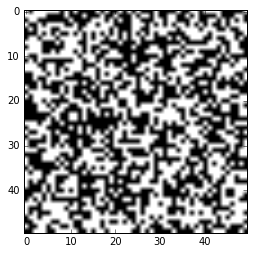

In [18]:
plt.imshow(whitenoise_stimuli_train[0], cmap='gray')

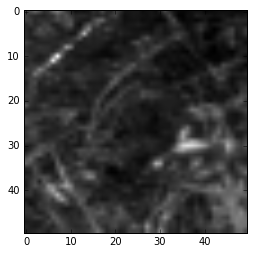

In [19]:
plt.imshow(naturalscene_stimuli_train[0], cmap='gray')

In [75]:
from os.path import join, expanduser
from scipy.stats import zscore

cells = [0, 1, 2, 3, 4]
NUM_BLOCKS = 6

def _loadexpt_h5(expt, filename):
    """Loads an h5py reference to an experiment on disk"""
    filepath = join(expanduser('~/experiments/data'), expt, filename + '.h5')
    return h5py.File(filepath, mode='r')

def loadexpt(expt='15-10-07', cells=cells, filename='whitenoise', train_or_test='train'):
    if train_or_test == 'train':
        nskip = 6000
    elif train_or_test == 'test':
        nskip = 0
    else:
        raise AssertionError('Mode is neither train nor test!')

    # load the hdf5 file
    with _loadexpt_h5(expt, filename) as f:

        expt_length = f[train_or_test]['time'].size

        # load the stimulus into memory as a numpy array, and z-score it
        stim = zscore(np.array(f[train_or_test]['stimulus']).astype('float32'))

        # apply clipping to remove the stimulus just after transitions
        num_blocks = NUM_BLOCKS if train_or_test == 'train' and nskip > 0 else 1
        valid_indices = np.arange(expt_length).reshape(num_blocks, -1)[:, nskip:].ravel()

        images = stim[valid_indices]
        # get the response for this cell (nsamples, ncells)
        resp = np.array(f[train_or_test]['response/firing_rate_10ms'][cells]).T[valid_indices]
        resp = resp[40:]

        return images, resp
        


In [76]:
out = loadexpt(expt='/mnt/data3/yamins/retina/', filename='whitenoise', train_or_test='train')

array([[-0.99519879, -1.00205684, -1.00223792, ..., -0.99818492,
         1.00094926,  0.99768323],
       [ 0.99640548,  0.99633896, -0.9995665 , ..., -0.99843645,
         0.99662912,  0.99497074],
       [ 0.99428886, -0.99904829,  1.00013351, ..., -1.00337553,
        -0.9968155 ,  0.99918401],
       ..., 
       [ 0.99913287, -0.99738997,  1.00472701, ..., -1.00220573,
        -1.00172007, -1.00073361],
       [ 0.99734169,  0.9983533 ,  0.99949932, ..., -0.99911749,
         1.00111401,  0.99480426],
       [ 1.00023329, -1.0043993 ,  1.00754225, ..., -0.99669164,
         0.9975723 ,  1.00020003]], dtype=float32)

## The Linear-Nonlinear Model

In [20]:
def linear_nonlinear_model(data, labels, nonlinearity=tf.nn.softplus):
    data_flat = tf.layers.flatten(data) 
    num_inputs = data_flat.shape.as_list()[-1]
    num_outputs = labels.shape.as_list()[-1]
    with tf.variable_scope("ln_model", reuse=tf.AUTO_REUSE):
        b = tf.get_variable(shape=[num_outputs],
                        dtype=tf.float32,
                        regularizer=tf.contrib.layers.l2_regularizer(1e-3),
                        name='bias') 
        W = tf.get_variable(shape=[num_inputs, num_outputs],
                        dtype=tf.float32,
                        regularizer=tf.contrib.layers.l2_regularizer(1e-3),
                        name='weights')
    out = tf.matmul(data_flat, W) + b   
    return nonlinearity(out)
    

In [21]:
def log_loss(logits, labels, C=1):
    log_loss = tf.reduce_mean(logits - (labels * tf.log(logits + 1e-8)))
    reg_loss = tf.add_n(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))
    return C * log_loss + reg_loss

In [71]:
T = 40
def get_temporal_batch(data, inds):
    inds0 = np.concatenate([range(ind, ind + T) for ind in inds])
    inds0 = np.minimum(inds0, data.shape[0]-1)
    data_ss = data[inds0]
    shp = data_ss.shape
    n0 = shp[0] / T
    data_ss = data_ss.reshape((n0, T) + shp[1:])
    return data_ss.astype(np.float32)    


cls = optimizer.TF_Optimizer(model_func=linear_nonlinear_model,
             loss_func=log_loss, 
             optimizer_class=tf.train.AdamOptimizer,
             batch_size=5000,
             train_iterations=1001,
             sess=sess,
             train_shuffle=True,
             optimizer_kwargs = {'learning_rate':1e-3,
                                  #'momentum': 0.9
                                },
             data_processors={'data': get_temporal_batch}
            )

In [72]:
with tf.variable_scope("ln_test5", reuse=tf.AUTO_REUSE):
    cls.fit(whitenoise_stimuli_train[:], whitenoise_responses_train[:][:5].T)

iteration 0 loss 82.141
iteration 100 loss 67.784
iteration 200 loss 68.474
iteration 300 loss 66.132
iteration 400 loss 70.249
iteration 500 loss 68.187
iteration 600 loss 70.960
iteration 700 loss 68.521
iteration 800 loss 68.319
iteration 900 loss 66.302
iteration 1000 loss 68.626


In [83]:
out[0].shape

(323802, 50, 50)

In [ ]:
with tf.variable_scope("ln_test5", reuse=tf.AUTO_REUSE):
    cls.fit(out[0][40:], out[1])

iteration 0 loss 2.491
iteration 100 loss -3.529
iteration 200 loss -5.090


### LNLN model

In [ ]:
def lnln_model(data, labels, num_intermediate, nonlinearity=tf.nn.softplus):
    data_flat = tf.layers.flatten(data) 
    num_inputs = data_flat.shape.as_list()[-1]
    num_outputs = labels.shape.as_list()[-1]
    with tf.variable_scope("ln_model", reuse=tf.AUTO_REUSE):
        b1 = tf.get_variable(shape=[num_intermediate],
                        dtype=tf.float32,
                        regularizer=tf.contrib.layers.l2_regularizer(1e-3),
                        name='bias1') 
        W1 = tf.get_variable(shape=[num_inputs, num_intermediate],
                        dtype=tf.float32,
                        regularizer=tf.contrib.layers.l2_regularizer(1e-3),
                        name='weights1')
        b2 = tf.get_variable(shape=[num_outputs],
                        dtype=tf.float32,
                        regularizer=tf.contrib.layers.l2_regularizer(1e-3),
                        name='bias2') 
        W2 = tf.get_variable(shape=[num_intermediate, num_outputs],
                        dtype=tf.float32,
                        regularizer=tf.contrib.layers.l2_regularizer(1e-3),
                        name='weights2')        
    intermediate = nonlinearity(tf.matmul(data_flat, W1) + b1)
    out = nonlinearity(tf.matmul(intermediate, W2) + b2)
    return out
    

## Multilayer Convolutional Models

In [73]:
from tfutils import model as tf_models

In [74]:
def cnn_model(data, labels, sigma=0.1, seed=0):

    # graph building stage
    with tf.variable_scope('cnn_model', reuse=tf.AUTO_REUSE):
        with tf.variable_scope('conv1'):
            c1 = tf_models.conv(data, 
                                out_depth=16, 
                                ksize=[15,15], 
                                strides=[1,1,1,1], 
                                padding='VALID', 
                                activation=None, 
                                batch_norm=False, 
                                weight_decay=1e-3)   
            
            r1 = tf.nn.relu(c1)

        with tf.variable_scope('conv2'):
            c2 = tf_models.conv(r1, 
                            out_depth=8, 
                            ksize=[9,9],
                            strides=[1,1,1,1],
                            padding='VALID',
                            activation=None,
                            batch_norm=False,
                            weight_decay=1e-3)

            
            r2 = tf.nn.relu(c2)

        with tf.variable_scope('readout'):
            out = tf_models.fc(r2, 
                           out_depth=5,
                           kernel_init='random_normal',
                           kernel_init_kwargs={'mean':0.0, 'stddev':0.05},
                           activation='softplus', 
                           bias=0, 
                           batch_norm=False, 
                           weight_decay=1e-3) 

    return out

## Acknowledgements

The material in this lecture was adapted from an assigment in CS 375 taught in Fall 2017 by Aran Nayebi, which was in turn taken from NEPR 208 (Neurosciences Computational Core Module), taught in Spring 2016 by Stephen A Baccus and Niru Maheswaranathan. The data used in this tutorial is from the Baccus Lab at Stanford.

## References

1. Stephen A Baccus, Bence P Olveczky, Mihai Manu, and Markus Meister. A retinal circuit that computes object motion.  The Journal of Neuroscience, 28(27):6807–6817, 2008.

2. Toshihiko Hosoya, Stephen A Baccus, and Markus Meister. Dynamic predictive coding by the retina. Nature, 436(7047):71–77, 2005.

3. Mandyam V Srinivasan, Simon B Laughlin, and Andreas Dubs. Predictive coding: a fresh view of inhibition in the retina. Proceedings of the Royal Society of London. Series B. Biological Sciences, 216(1205):427–459, 1982.

4. EJ Chichilnisky. A simple white noise analysis of neuronal light responses. Network: Computation in Neural Systems, 12(2):199-213, 2001.

5. Odelia Schwartz, Jonathan W Pillow, Nicole C Rust, and Eero P Simoncelli. Spike-triggered neural characterization. Journal of Vision, 6(4):484-507, 2006.

6. Lane T McIntosh, Niru Maheswaranathan, Aran Nayebi, Surya Ganguli, and Stephen A. Baccus. Deep learning models of the retinal response to natural scenes. In Advances in Neural Information Processing Systems (NIPS 2016), pp. 1369-1377, 2016.